In [1]:
import warnings
import gseapy as gp
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Tuple
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

from datasets import load_GSE48452, load_GSE49541, load_GSE89632, load_GSE83452
from datasets import GeneExpressionDataset

# Feature selection for biomarker discovery

## Load datasets

Each dataset contains (1) gene expression data, (2) condition labels, (3) condition names, and (4) gene symbols.

In [2]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    dataset_GSE48452 = load_GSE48452(return_deseq=False)
    print(f'Conditions GSE48452: {dataset_GSE48452.label_names}')

    dataset_GSE49541 = load_GSE49541(return_deseq=False)
    print(f'Conditions GSE49541: {dataset_GSE49541.label_names}')

    dataset_GSE89632 = load_GSE89632(return_deseq=False)
    print(f'Conditions GSE89632: {dataset_GSE89632.label_names}')

    dataset_GSE83452 = load_GSE83452(return_deseq=False)
    print(f'Conditions GSE83452: {dataset_GSE83452.label_names}')

Conditions GSE48452: ['NAFL', 'NASH', 'control', 'healthy obese']
Conditions GSE49541: ['NAFL', 'NASH']
Conditions GSE89632: ['NAFL', 'NASH', 'control']
Conditions GSE83452: ['NASH', 'control', 'other']


We define a function `prepare_data` that converts the original dataset into a binary classification dataset using the specified conditions. Next, a function `genes_rfe` performs cross-validation Recursive Feature Elimination (RFE) with a Random Forest classifier. This function returns a list of relevant features (genes or gene lists).

In [73]:
def prepare_data(dataset: GeneExpressionDataset, conditions: Tuple[str, str]) -> Tuple[np.ndarray, np.ndarray]:
    index_condition_0 = dataset.label_names.index(conditions[0])
    index_condition_1 = dataset.label_names.index(conditions[1])
    indices_0 = np.where(dataset.labels == index_condition_0)[0]
    indices_1 = np.where(dataset.labels == index_condition_1)[0]
    indices = np.concatenate([indices_0, indices_1])
    X = dataset.data[indices]
    y = dataset.labels[indices]
    y_copy = y.copy()
    y_copy[y == index_condition_0] = 0
    y_copy[y == index_condition_1] = 1
    return X, y_copy

def genes_rfe(dataset: GeneExpressionDataset, conditions: Tuple[str, str], n_features_to_select: int) -> List[str]:

    # Features are gene expression values and labels are sample conditions (binary)
    X, y = prepare_data(dataset, conditions)
    np.random.seed(42)

    # We use a random forest classifier as the estimator
    model = RandomForestClassifier(random_state=42)

    # We use cross-validation to rank the features more robustly
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rfe_rankings = []
    rfe_scores = []
    for train_index, test_index in cv.split(X, y):

        # Balance training data
        max_num = min(np.sum(y[train_index] == 0), np.sum(y[train_index] == 1))
        idx_0 = np.random.permutation(np.where(y[train_index] == 0)[0])[:max_num]
        idx_1 = np.random.permutation(np.where(y[train_index] == 1)[0])[:max_num]
        train_index = np.concatenate([idx_0, idx_1])
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]

        # Fit RFE on the training data
        rfe = RFE(estimator=model, n_features_to_select=n_features_to_select, step=0.05)
        rfe.fit(X_train, y_train)
        rfe_rankings.append(rfe.ranking_)

        # Evaluate the model on the test data
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        rfe_scores.append(score)

    # Calculate selected genes
    rfe_rankings = np.stack(rfe_rankings).mean(0)
    genes = [dataset.gene_symbols[i] for i in np.argsort(rfe_rankings)[:n_features_to_select]]
    return genes, np.mean(rfe_scores)

## NAFL vs NASH

First, we investigate the NAFL (steatosis) vs NASH condition. For each dataset, we select 100 features through RFE and print their correlation with the condition.

GSE48452 - Mean score (accuracy): 0.819047619047619


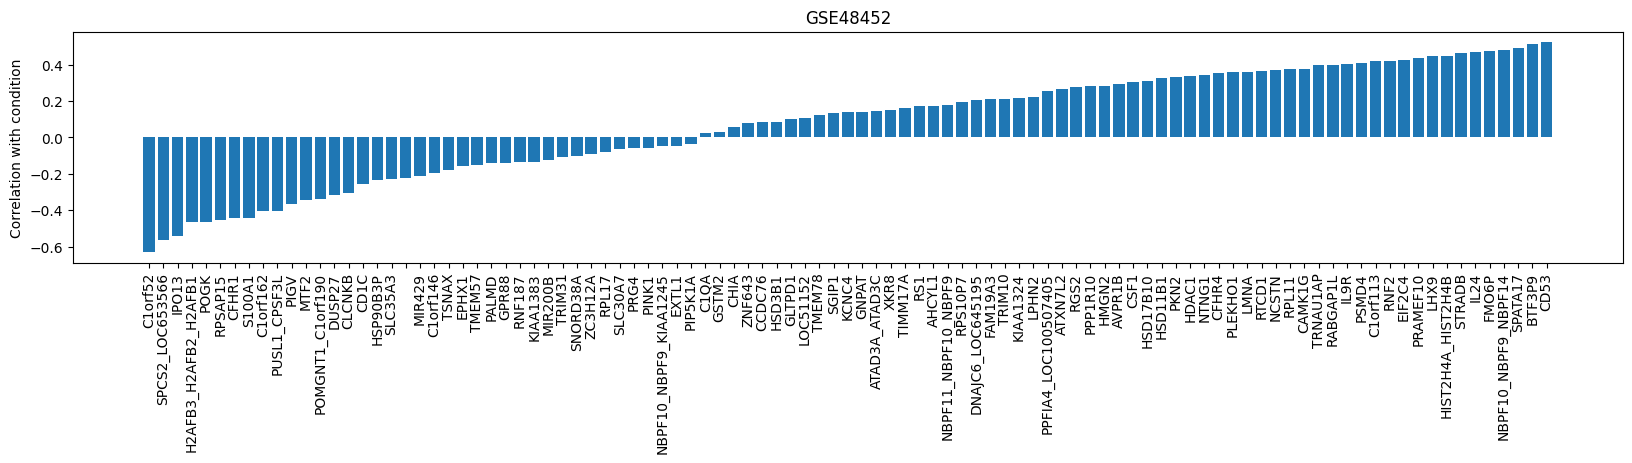

GSE49541 - Mean score (accuracy): 0.9161904761904761


/home/diego/miniconda3/envs/bio/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/diego/miniconda3/envs/bio/lib/python3.9/site-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


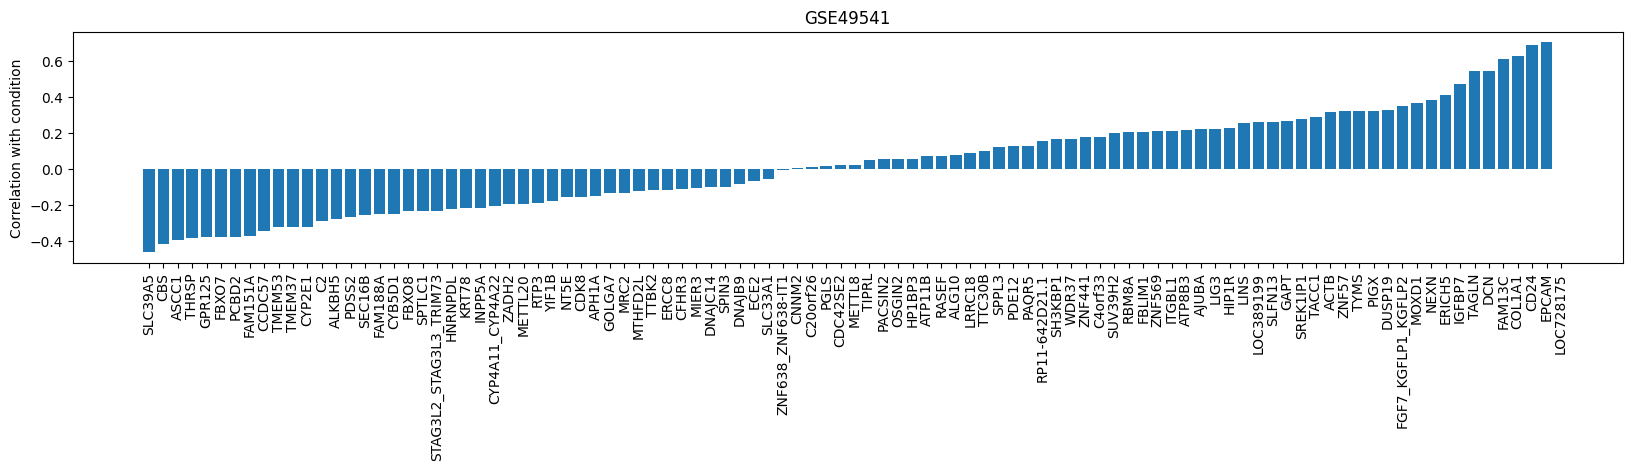

GSE89632 - Mean score (accuracy): 0.8964285714285714


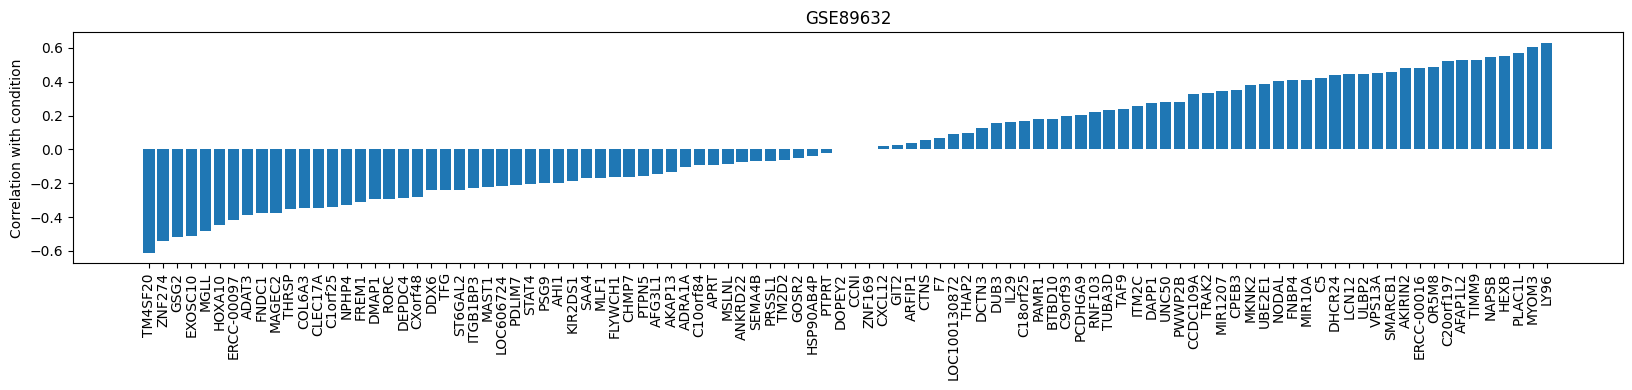

In [74]:
conditions = ('NAFL', 'NASH')
n_features_to_select = 100

def gene_selection(name: str, dataset: GeneExpressionDataset, conditions: Tuple[str, str], n_features_to_select: int):
    
    # Compute RFE
    genes, score = genes_rfe(dataset, conditions, n_features_to_select)
    print(f'{name} - Mean score (accuracy): {score}')

    # Compute correlation with condition for all RFE selected genes
    indices = [dataset.gene_symbols.index(gene) for gene in genes]
    X, y = prepare_data(dataset, conditions)
    corrs = np.array([np.corrcoef(X[:, i], y)[0, 1] for i in indices])
    if isinstance(genes[0], list):
        xs = ['_'.join(g[:3]) for g in genes]
    else:
        xs = genes

    # Plot correlation with condition for all RFE selected genes
    plt.figure(figsize=(20, 3))
    plt.bar(np.array(xs)[np.argsort(corrs)], corrs[np.argsort(corrs)])
    plt.xticks(rotation=90)
    plt.title(name)
    plt.ylabel('Correlation with condition')
    plt.show()

    if isinstance(genes[0], list):
        genes = [item for sublist in genes for item in sublist]
    genes = list(set(genes))
    
    return genes

genes_GSE48452 = gene_selection('GSE48452', dataset_GSE48452, conditions, n_features_to_select)
genes_GSE49541 = gene_selection('GSE49541', dataset_GSE49541, conditions, n_features_to_select)
genes_GSE89632 = gene_selection('GSE89632', dataset_GSE89632, conditions, n_features_to_select)

### Overrepresentation Analysis

Because the lists of genes do not overlap across datasets, we investigate pathways that are (over)represented in one or more datasets.

In [75]:
enr = gp.enrichr(gene_list=genes_GSE48452, gene_sets='KEGG_2021_Human', organism='Human')
pathways_GSE48452 = enr.results['Term'].values
enr.results.sort_values('Adjusted P-value', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Metabolism of xenobiotics by cytochrome P450,3/76,0.009602,0.584590,0,0,7.269569,33.773062,HSD11B1;GSTM2;EPHX1
1,KEGG_2021_Human,Complement and coagulation cascades,3/85,0.012998,0.584590,0,0,6.468750,28.093357,C1QA;CFHR1;CFHR4
2,KEGG_2021_Human,Hematopoietic cell lineage,3/99,0.019486,0.584590,0,0,5.521484,21.743837,CSF1;CD1C;IL9R
3,KEGG_2021_Human,Notch signaling pathway,2/59,0.045347,0.749032,0,0,6.156808,19.045592,NCSTN;HDAC1
4,KEGG_2021_Human,Steroid hormone biosynthesis,2/61,0.048145,0.749032,0,0,5.947503,18.041961,HSD11B1;HSD3B1
5,KEGG_2021_Human,Aldosterone synthesis and secretion,2/98,0.109279,0.749032,0,0,3.648414,8.077048,HSD3B1;CAMK1G
6,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,2/100,0.112990,0.749032,0,0,3.573596,7.792068,CSF1;IL24
7,KEGG_2021_Human,Mannose type O-glycan biosynthesis,1/23,0.124276,0.749032,0,0,7.919856,16.514873,POMGNT1
8,KEGG_2021_Human,Protein export,1/23,0.124276,0.749032,0,0,7.919856,16.514873,SPCS2
9,KEGG_2021_Human,Glycosylphosphatidylinositol (GPI)-anchor bios...,1/26,0.139314,0.749032,0,0,6.968421,13.734950,PIGV


In [76]:
enr = gp.enrichr(gene_list=genes_GSE49541, gene_sets='KEGG_2021_Human', organism='Human')
pathways_GSE49541 = enr.results['Term'].values
enr.results.sort_values('Adjusted P-value', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,One carbon pool by folate,2/20,0.004877,0.429157,0,0,21.442287,114.143048,MTHFD2L;TYMS
1,KEGG_2021_Human,Pyrimidine metabolism,2/56,0.034986,0.723610,0,0,7.134484,23.920572,NT5E;TYMS
2,KEGG_2021_Human,Complement and coagulation cascades,2/85,0.073607,0.723610,0,0,4.634928,12.092609,CFHR3;C2
3,KEGG_2021_Human,Proteoglycans in cancer,3/205,0.093419,0.723610,0,0,2.867356,6.797539,COL1A1;ACTB;DCN
4,KEGG_2021_Human,Terpenoid backbone biosynthesis,1/22,0.109404,0.723610,0,0,9.099817,20.135199,PDSS2
5,KEGG_2021_Human,Folate biosynthesis,1/26,0.127982,0.723610,0,0,7.642308,15.711569,PCBD2
6,KEGG_2021_Human,Glycosylphosphatidylinositol (GPI)-anchor bios...,1/26,0.127982,0.723610,0,0,7.642308,15.711569,PIGX
7,KEGG_2021_Human,Chemical carcinogenesis,3/239,0.131136,0.723610,0,0,2.450025,4.977277,FGF7;PAQR5;CYP2E1
8,KEGG_2021_Human,Platelet activation,2/124,0.138273,0.723610,0,0,3.147064,6.226535,COL1A1;ACTB
9,KEGG_2021_Human,Linoleic acid metabolism,1/29,0.141662,0.723610,0,0,6.822459,13.333186,CYP2E1


In [77]:
enr = gp.enrichr(gene_list=genes_GSE89632, gene_sets='KEGG_2021_Human', organism='Human')
pathways_GSE89632 = enr.results['Term'].values
enr.results.sort_values('Adjusted P-value', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Inflammatory bowel disease,2/65,0.041993,0.70274,0,0,6.425980,20.371958,RORC;STAT4
1,KEGG_2021_Human,Pertussis,2/76,0.055557,0.70274,0,0,5.467733,15.803679,C5;LY96
2,KEGG_2021_Human,RNA degradation,2/79,0.059490,0.70274,0,0,5.253909,14.826276,DDX6;EXOSC10
3,KEGG_2021_Human,Complement and coagulation cascades,2/85,0.067632,0.70274,0,0,4.872633,13.125272,F7;C5
4,KEGG_2021_Human,ECM-receptor interaction,2/88,0.071834,0.70274,0,0,4.701946,12.382069,COL6A3;FREM1
5,KEGG_2021_Human,Other glycan degradation,1/18,0.086310,0.70274,0,0,11.814023,28.942114,HEXB
6,KEGG_2021_Human,Glycosaminoglycan degradation,1/19,0.090883,0.70274,0,0,11.157127,26.756884,HEXB
7,KEGG_2021_Human,Steroid biosynthesis,1/20,0.095432,0.70274,0,0,10.569378,24.831030,DHCR24
8,KEGG_2021_Human,NF-kappa B signaling pathway,2/104,0.095563,0.70274,0,0,3.961184,9.300759,CXCL12;LY96
9,KEGG_2021_Human,Salmonella infection,3/249,0.128922,0.70274,0,0,2.470958,5.061882,TUBA3D;DCTN3;LY96


The following plot shows overrepresented pathways and the number of datasets they appear in.

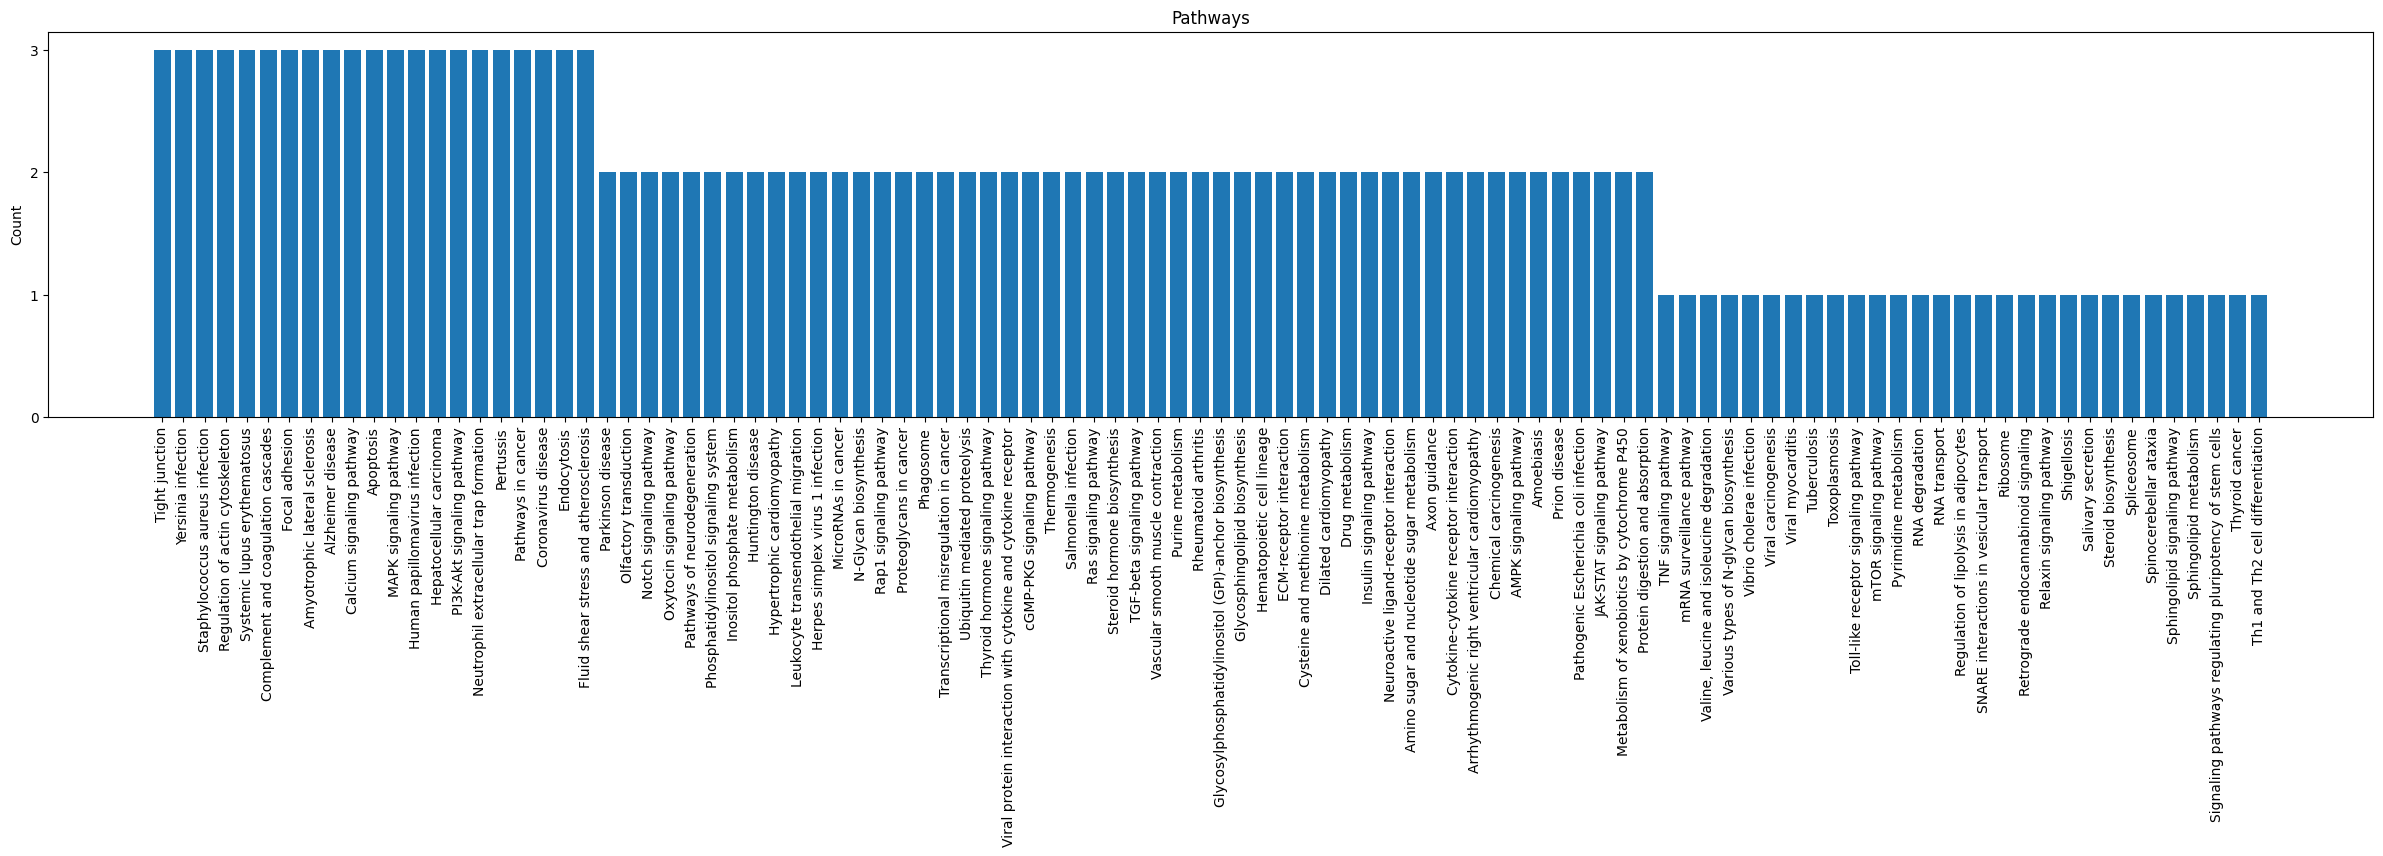

In [78]:
all_pathways = pathways_GSE48452.tolist() + pathways_GSE49541.tolist() + pathways_GSE89632.tolist()
values, counts = np.unique(all_pathways, return_counts=True)
order = np.argsort(counts)[::-1][:100]
pathways = values[order]

plt.figure(figsize=(30, 5))
plt.bar(pathways, counts[order])
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 4, 1))
plt.ylabel('Count')
plt.title('Pathways')
plt.show()

## Control vs NASH

In a similar fashion, we now investigate the Control vs NASH condition.

GSE48452 - Mean score (accuracy): 0.8238095238095238


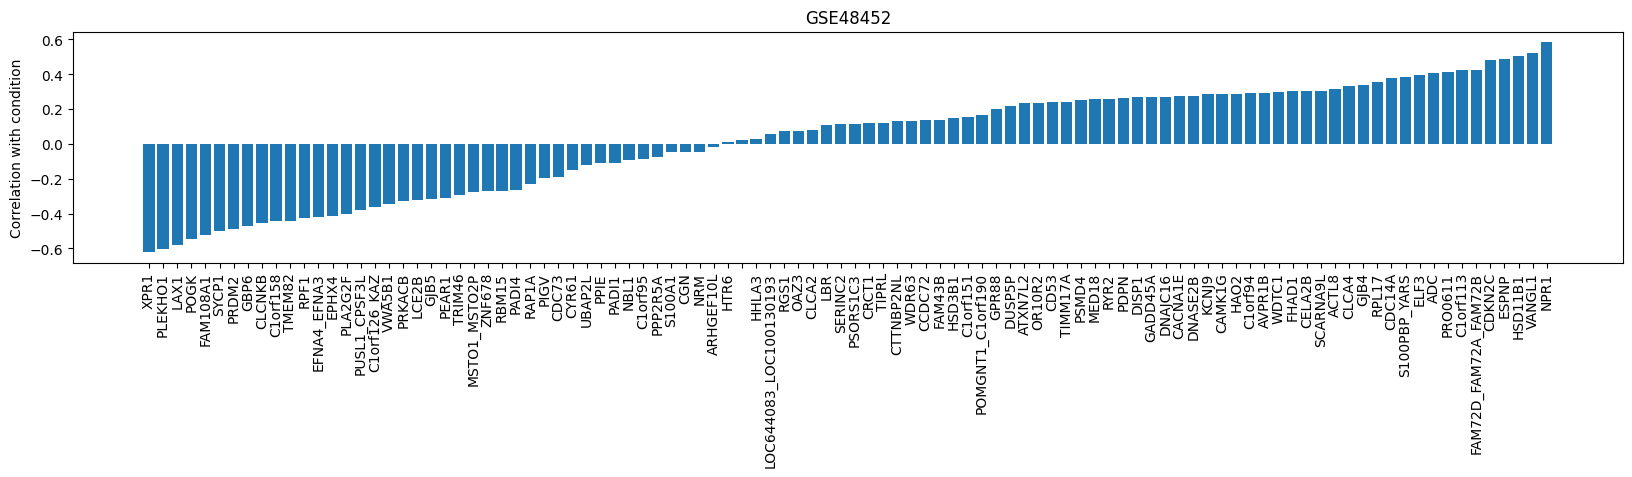

GSE83452 - Mean score (accuracy): 0.6482758620689655


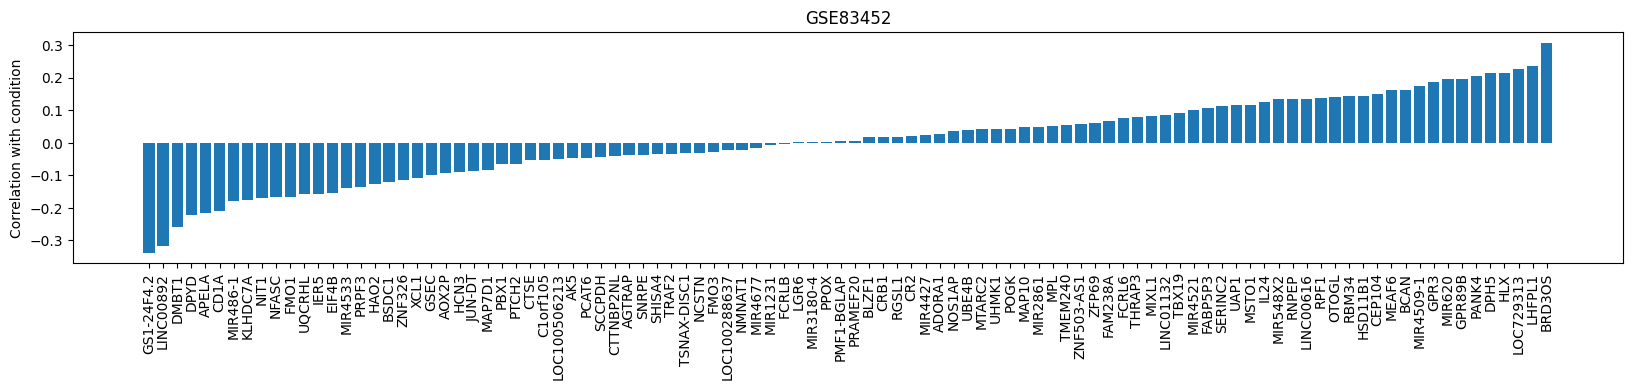

GSE89632 - Mean score (accuracy): 1.0


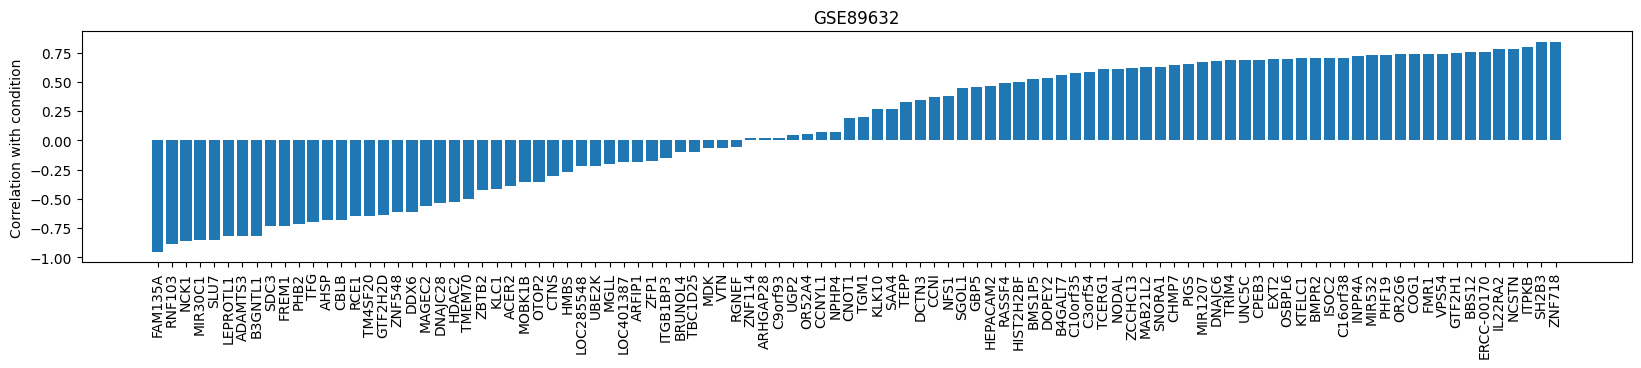

In [79]:
conditions = ('control', 'NASH')
n_features_to_select = 100

genes_GSE48452 = gene_selection('GSE48452', dataset_GSE48452, conditions, n_features_to_select)
genes_GSE83452 = gene_selection('GSE83452', dataset_GSE83452, conditions, n_features_to_select)
genes_GSE89632 = gene_selection('GSE89632', dataset_GSE89632, conditions, n_features_to_select)

### Overrepresentation Analysis

In [80]:
enr = gp.enrichr(gene_list=genes_GSE48452, gene_sets='KEGG_2021_Human', organism='Human')
pathways_GSE48452 = enr.results['Term'].values
enr.results.sort_values('Adjusted P-value', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Pancreatic secretion,6/102,0.000019,0.002669,0,0,12.129902,131.823318,PLA2G2F;RYR2;RAP1A;CELA2B;CLCA2;CLCA4
1,KEGG_2021_Human,Renin secretion,4/69,0.000531,0.037152,0,0,11.731953,88.473522,NPR1;CLCA2;PRKACB;CLCA4
2,KEGG_2021_Human,Oxytocin signaling pathway,5/154,0.001495,0.055097,0,0,6.432202,41.843905,RYR2;KCNJ9;NPR1;PRKACB;CAMK1G
3,KEGG_2021_Human,Calcium signaling pathway,6/240,0.001938,0.055097,0,0,4.941679,30.865543,RYR2;HTR6;AVPR1B;CACNA1E;PRKACB;CAMK1G
4,KEGG_2021_Human,Aldosterone synthesis and secretion,4/98,0.001968,0.055097,0,0,8.100655,50.474118,NPR1;HSD3B1;PRKACB;CAMK1G
5,KEGG_2021_Human,MAPK signaling pathway,6/294,0.005250,0.111374,0,0,4.004085,21.019676,EFNA3;RAP1A;GADD45A;EFNA4;CACNA1E;PRKACB
6,KEGG_2021_Human,Vascular smooth muscle contraction,4/133,0.005878,0.111374,0,0,5.892367,30.266095,PLA2G2F;AVPR1B;NPR1;PRKACB
7,KEGG_2021_Human,cAMP signaling pathway,5/216,0.006364,0.111374,0,0,4.527907,22.897888,RYR2;HTR6;RAP1A;NPR1;PRKACB
8,KEGG_2021_Human,Ras signaling pathway,5/232,0.008532,0.132722,0,0,4.205338,20.033885,PLA2G2F;EFNA3;RAP1A;EFNA4;PRKACB
9,KEGG_2021_Human,Cushing syndrome,4/155,0.009976,0.139670,0,0,5.028273,23.167930,RAP1A;CDKN2C;HSD3B1;PRKACB


In [81]:
enr = gp.enrichr(gene_list=genes_GSE83452, gene_sets='KEGG_2021_Human', organism='Human')
pathways_GSE83452 = enr.results['Term'].values
enr.results.sort_values('Adjusted P-value', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Drug metabolism,3/108,0.016960,0.759432,0,0,5.830633,23.770869,DPYD;FMO1;FMO3
1,KEGG_2021_Human,Thiamine metabolism,1/15,0.072455,0.759432,0,0,14.347763,37.659814,AK5
2,KEGG_2021_Human,Hematopoietic cell lineage,2/99,0.087925,0.759432,0,0,4.166421,10.129717,CR2;CD1A
3,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,2/100,0.089437,0.759432,0,0,4.123698,9.955522,IL24;XCL1
4,KEGG_2021_Human,Pantothenate and CoA biosynthesis,1/21,0.099960,0.759432,0,0,10.040404,23.122924,DPYD
5,KEGG_2021_Human,Sphingolipid signaling pathway,2/119,0.119519,0.759432,0,0,3.450724,7.330307,ADORA1;TRAF2
6,KEGG_2021_Human,beta-Alanine metabolism,1/30,0.139710,0.759432,0,0,6.921282,13.622395,DPYD
7,KEGG_2021_Human,Glyoxylate and dicarboxylate metabolism,1/30,0.139710,0.759432,0,0,6.921282,13.622395,HAO2
8,KEGG_2021_Human,Nicotinate and nicotinamide metabolism,1/35,0.161037,0.759432,0,0,5.901961,10.777711,NMNAT1
9,KEGG_2021_Human,Spliceosome,2/150,0.172791,0.759432,0,0,2.723662,4.781854,PRPF3;SNRPE


In [82]:
enr = gp.enrichr(gene_list=genes_GSE89632, gene_sets='KEGG_2021_Human', organism='Human')
pathways_GSE89632 = enr.results['Term'].values
enr.results.sort_values('Adjusted P-value', ascending=True).head(10)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Glycosaminoglycan biosynthesis,2/53,0.028910,0.545018,0,0,7.942777,28.145745,EXT2;B4GALT7
1,KEGG_2021_Human,Notch signaling pathway,2/59,0.035213,0.545018,0,0,7.104547,23.774319,HDAC2;NCSTN
2,KEGG_2021_Human,Sulfur relay system,1/8,0.039314,0.545018,0,0,28.705628,92.896785,NFS1
3,KEGG_2021_Human,Inositol phosphate metabolism,2/73,0.051720,0.545018,0,0,5.699626,16.881746,INPP4A;ITPKB
4,KEGG_2021_Human,RNA degradation,2/79,0.059490,0.545018,0,0,5.253909,14.826276,DDX6;CNOT1
5,KEGG_2021_Human,Axon guidance,3/182,0.063223,0.545018,0,0,3.407418,9.408154,BMPR2;UNC5C;NCK1
6,KEGG_2021_Human,ErbB signaling pathway,2/85,0.067632,0.545018,0,0,4.872633,13.125272,CBLB;NCK1
7,KEGG_2021_Human,ECM-receptor interaction,2/88,0.071834,0.545018,0,0,4.701946,12.382069,VTN;FREM1
8,KEGG_2021_Human,Thiamine metabolism,1/15,0.072455,0.545018,0,0,14.347763,37.659814,NFS1
9,KEGG_2021_Human,TGF-beta signaling pathway,2/94,0.080483,0.545018,0,0,4.393966,11.071494,BMPR2;NODAL


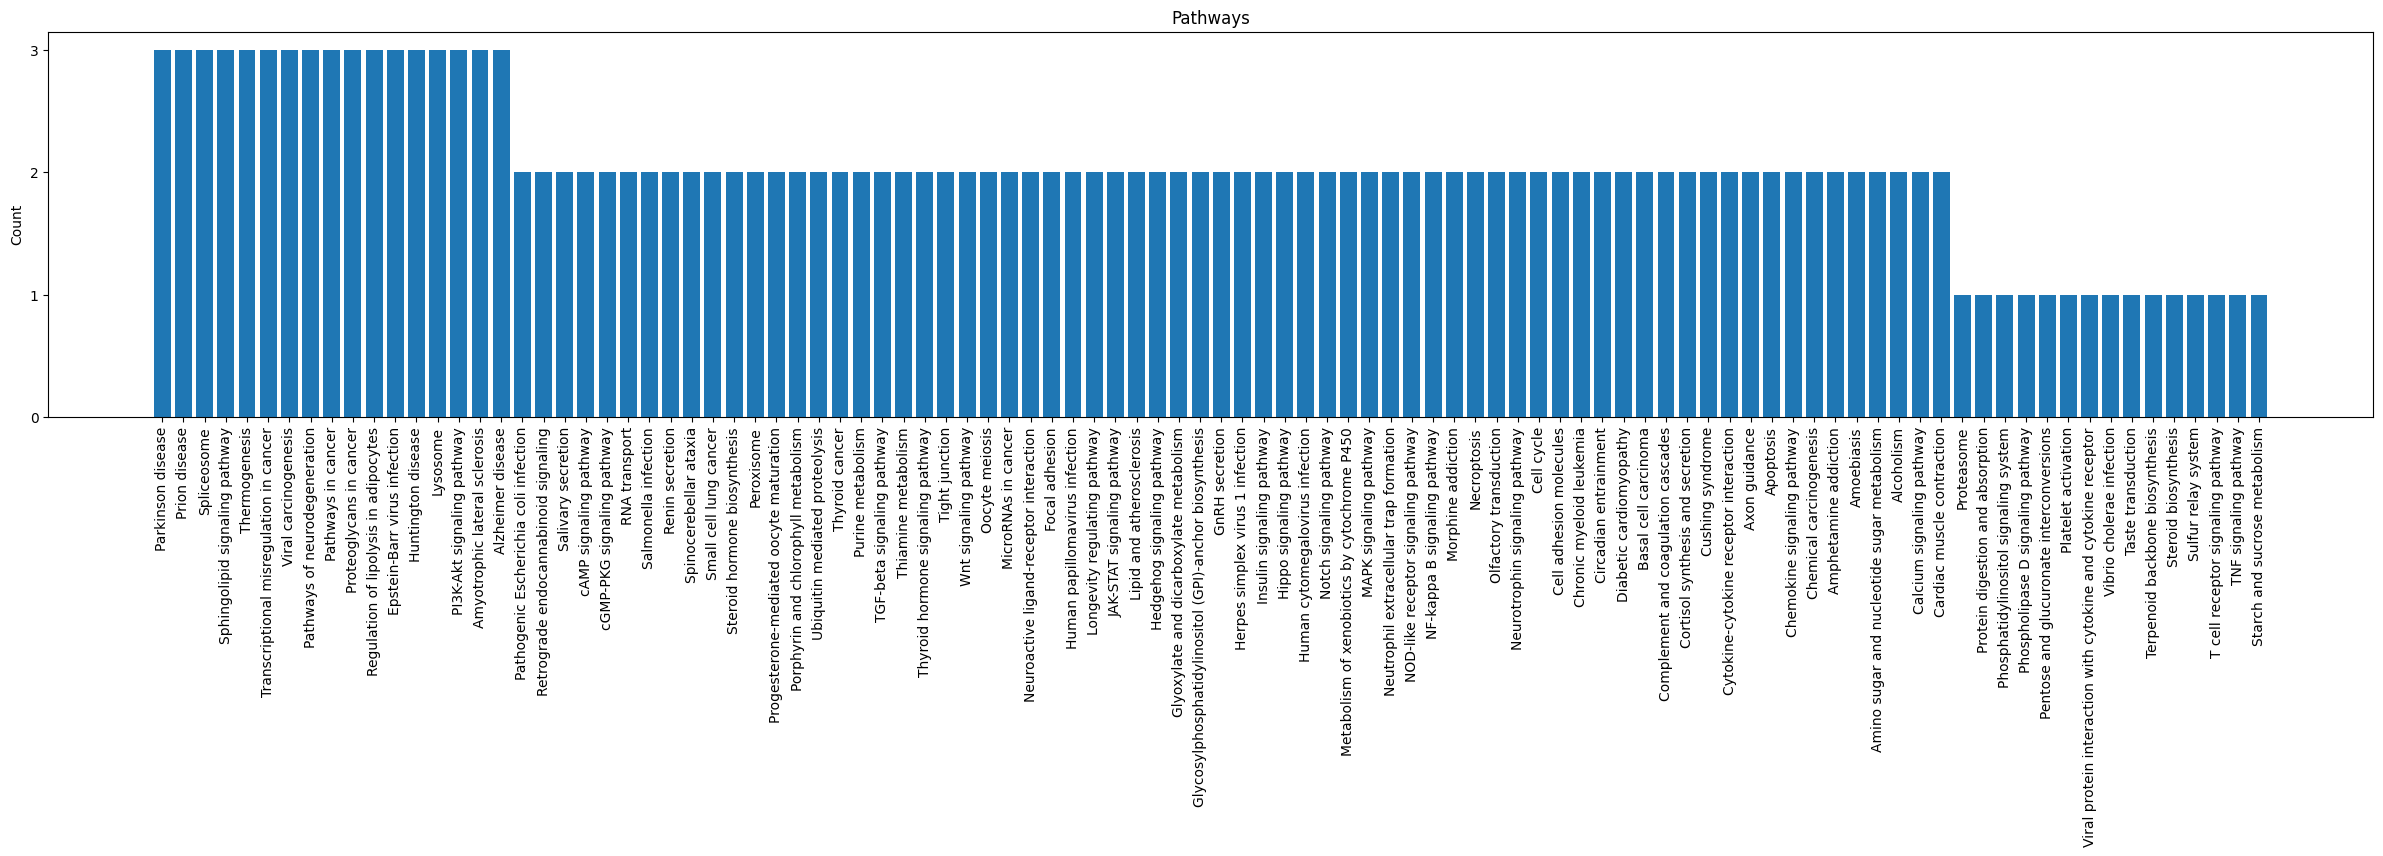

In [83]:
all_pathways = pathways_GSE48452.tolist() + pathways_GSE83452.tolist() + pathways_GSE89632.tolist()
values, counts = np.unique(all_pathways, return_counts=True)
order = np.argsort(counts)[::-1][:100]
pathways = values[order]

plt.figure(figsize=(30, 5))
plt.bar(pathways, counts[order])
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 4, 1))
plt.ylabel('Count')
plt.title('Pathways')
plt.show()